# INFO8010: Project
Detailed description: see [README.md](README.md)

NB: references in this notebook point towards the README's references

## 0. Preamble

Importing torch and required libraries, plus miscellaneous definitions

### 0.0. Installing packages

In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 123 kB 25.8 MB/s eta 0:00:01
     |████████████████████████████████| 213 kB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 20.4 MB/s eta 0:00:01    |███████████▎                    | 5.5 MB 20.4 MB/s eta 0:00:01
     |████████████████████████████████| 750.6 MB 24.2 MB/s eta 0:00:01    |██▎                             | 53.8 MB 26.6 MB/s eta 0:00:27     |██████████████████              | 420.8 MB 24.3 MB/s eta 0:00:14��█████████████▍    | 642.0 MB 22.7 MB/s eta 0:00:05
     |████████████████████████████████| 2.9 MB 34.0 MB/s eta 0:00:01
     |████████████████████████████████| 21.0 MB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 245 kB 28.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 29.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found exist

### 0.1. Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torchdata
import torch.optim as optim
import torchvision.transforms as imgtransforms

from typing import Tuple
from math import ceil

from torchvision import models as imgmodels

from data import SpecDataset, N_MELS, HOP_LENGTHS
from fastprogress.fastprogress import master_bar, progress_bar

### 0.2. Audio player & device

As this features does not work on VS Code, here is a work-around stolen from [here](https://github.com/microsoft/vscode-jupyter/issues/1012#issuecomment-785410064) to have a working audio player on VSC.

In [3]:
import ipywidgets as widgets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vsc_check = widgets.Checkbox(
    value=False,
    description="VS Code user ?",
    disabled=False,
    tooltip="Do you use VS Code to see this notebook ?",
    indent=False,
)

display(vsc_check)

Checkbox(value=False, description='VS Code user ?', indent=False)

In [4]:
import IPython.display as ipd
import json

def VSC_Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return ipd.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

def NonVSC_Audio(audio, sr):
    return ipd.Audio(audio, rate=sr)

audio_player = VSC_Audio if vsc_check.value else NonVSC_Audio

## 1. Data loading

First, define:
1. the transformer used to pre-process the data
1. the loader to be used to load the data for the GTZAN dataset (to start with, to be patched if not sufficient)

### 1.1. Transformer

**Reminder**: Mel spectrogram "algo"
1. Take a window of `win_length` samples of the input at current position
2. Compute fft with frequency spectrum is sepatated in `n_mels` evenly spaced frequencies, then apply mel scale on it (log-like), use `n_fft` samples for that computation
3. Append the computed column to the result
4. Move the window of `hop_length`
5. Restart in 1.

For an input of length `N`, this results in a matrix that has:
- `N // hop_length + 1` columns
- `n_mels` rows

In our case, as input sequence are cropped at `sequence_duration` seconds, aim at:
- Width: `ceil(sequence_duration × sampling_rate / hop_length)` columns
- Height: `n_mels`

#### Variable input length support

Later on, we will require the spectrogram length (number of columns) to express like `L = 16×n + 1` so that resnet behaves well. We will directly crop the input waveform at the right length, so that we avoid to zero-pad the spectrograms what would mean an abrupt, unwanted end of the music.

We get: `L = N // hop_length + 1 = 16×n+1`

Hence:  `N // hop_length = 16×n`

Thus:   `N = (16×hop_length)×n+r`, where `r` is an integer in the interval `[0, hop_length[`

In [5]:
# Duration of the sequence to randomly crop out of the original sequence
sequence_durations = (20, 27)    # s

# parameters value taken from reference [1]
gtzan_sampling_rate = 22050 # Hz
sampling_rate = 12000      # 12 kHz

# sampling_rate is a multiple of 16 so it's fine if seconds are even for 
# the spectrograms to shape like 16×n+1 for the resnet nice behaviour
min_spec_length_seconds = 20
max_spec_length_seconds = 28
min_spec_length, max_spec_length = [int((x * sampling_rate) / HOP_LENGTHS[1] + 1) for x in [
    min_spec_length_seconds, max_spec_length_seconds
]]

class OurRandomCrop(object):
    """
    Cannot work because of concurrency, and have to stack tensors of same dimensions
    in a same minibatch...
    """
    def __init__(self, height: int, bounds: Tuple[int, int], step: int = 1):
        self.height = height
        self.base = bounds[0]
        self.num = int(ceil((bounds[1] - bounds[0]) / step))
        self.step = step
        self.batch_size = 5
        self.counter = 0
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.counter == 0:
            self.counter = self.batch_size - 1
            self.r = int(torch.randint(self.num, (1, 1)))
        self.counter = (self.counter + 1) % 5
        l = self.base + self.r * self.step
        return imgtransforms.RandomCrop((self.height, l))(x)
    

def make_spec_transform(spec_length: int):
    return imgtransforms.Compose([
        imgtransforms.RandomCrop((N_MELS, spec_length)),
        imgtransforms.RandomApply([
            imgtransforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.4, hue=0.1),
            imgtransforms.GaussianBlur(3, sigma=(0.1, 1)),
            imgtransforms.RandomErasing(p=0.4)
        ], p=0.7)
    ])

transform = make_spec_transform(min_spec_length)

### 1.2. Dataset and data loader

We split the original dataset (1000 sequences long) into test and train set:
- Training set will be 70% of the dataset
- Test set will contain the remaining sequences

In [6]:
batch_size = 5
num_workers = 1

dataset = SpecDataset(
    "data/gtzan",
    sampling_rate=sampling_rate,
    transform=transform,
    download=True,
)

dataset_length = len(dataset)
trainset_length = int(0.7 * dataset_length)
testset_length = dataset_length - trainset_length
trainset, testset = torchdata.random_split(dataset, [trainset_length, testset_length])

data_loader = torchdata.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

train_loader = torchdata.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = torchdata.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

NB: an element `spec` of the dataset has the dimensions: (batch, channel, frequency, time), where
- batch correspond to the id of the sample in the batch
- channel is artificial construction to use resnet models, spans across the different spectrograms
- frequency spans across the frequency range of the window
- time indicate the time of the window

### 1.3. Test loading

spec shape: torch.Size([5, 3, 128, 801])


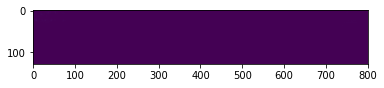

In [7]:
spec, genre = next(iter(data_loader))
print(f"spec shape: {spec.shape}")
plt.imshow(spec[0][0], vmin=0, vmax=0.5)


## 2. Defining the encoder and the decoder

Define as `nn.Module`s:
- the encoder
   - Input: waveform
   - Output: latent representation
- the decoder
   - Input: latent representation
   - Ouptput: waveform
- an encoder-decoder that chains them both for convenience

### Shapes
| Stage                  | Shape            | Meaning                      |
| ---------------------- | ---------------- | ---------------------------- |
| Input `spec`           | [5, 3, 128, 801] | (batch, channel, freq, time) |
| Output of `ResNet34Cut`| [5, 256, 8, 51]  | (batch, stack, freq2, time2) |
| Intput of LSTM         | [5, 2048, 51]    | (batch, freq3, time3)        |
| Output of LSTM         | [5, 2048]        | (batch, component)           |

### 2.1 Resnet utilities

Cut the resnet34 architecture to keep more detailed information (and not loose temporal dimension):

NB: the `forward` implementation is almost copy-pasted from the torchvision sources, from [here](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet34).

Also, define an inverse module for that architecture to be used in the decoder.

In [55]:
class ResNet34Cut(imgmodels.ResNet):
    def __init__(self, pretrained=True):
        resnet = imgmodels.resnet34(pretrained=pretrained)
        for k, v in resnet.__dict__.items():
            setattr(self, k, v)
            
        del self.layer4
        del self.avgpool
        del self.fc
        
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.size = [batch(B), channels(3), n_mels(128), spec_length(L=16×N+1)]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x.size = [batch(B), channels(256), height(8), length(f(L)=N+1)]
        # f(L) = ???, at least f(16×n+1) = n+1   for int n
        #         ↳ Because of mess of conv & pooling layers in resnet

        return x

class InverseResNet34Cut(nn.Module):
    channels = [256, 128, 64, 64, 3]
    kernel_sizes = [(3, 3), (3, 3), (3, 3), (3, 3)]
    mid_kernel_size = (3, 3)
    num_mid_layers = [2, 1, 1, 0]

    def __init__(self):
        super().__init__()
        self.layer1 = self._make_layer(
            in_channels = self.channels[0],
            out_channels = self.channels[1],
            kernel_size = self.kernel_sizes[0],
            output_padding = (1, 0),
            num_mid_layers = self.num_mid_layers[0],
            mid_kernel_size = self.mid_kernel_size,
        )
        
        self.layer2 = self._make_layer(
            in_channels = self.channels[1], 
            out_channels = self.channels[2],
            kernel_size = self.kernel_sizes[1],
            num_mid_layers = self.num_mid_layers[1],
            mid_kernel_size = self.mid_kernel_size
        )
        
        self.layer3 = self._make_layer(
            in_channels = self.channels[2], 
            out_channels = self.channels[3],
            kernel_size = self.kernel_sizes[2],
            num_mid_layers =self.num_mid_layers[2],
            mid_kernel_size = self.mid_kernel_size
        )

        self.layer4 = self._make_layer(
            in_channels = self.channels[3],
            out_channels = self.channels[4],
            kernel_size = self.kernel_sizes[3],
            num_mid_layers = self.num_mid_layers[3],
            mid_kernel_size = self.mid_kernel_size,
        )
    
    def _make_transition_layer(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Tuple[int, int],
        padding: Tuple[int, int] = (1, 1),
        output_padding: Tuple[int, int] = (1, 0)
    ) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=(2, 2),
                padding=padding,
                output_padding=output_padding
            ),
            nn.BatchNorm2d(out_channels, momentum=0.01),
            nn.ReLU()
        )
    
    def _make_mid_layer(self, channels: int, kernel_size: int) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=kernel_size,
                padding=1
            ),
            nn.BatchNorm2d(channels, momentum=0.01),
            nn.ReLU()
        )
    
    def _make_layer(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Tuple[int, int],
        num_mid_layers: int,
        mid_kernel_size: Tuple[int, int],
        padding: Tuple[int, int] = (1, 1),
        output_padding: Tuple[int, int] = (1, 0),
    ) -> nn.Module:
        l = []
        l.append(self._make_transition_layer(
            in_channels, out_channels, kernel_size, padding, output_padding
        ))
        for _ in range(num_mid_layers):
            l.append(self._make_mid_layer(out_channels, mid_kernel_size))
        
        return nn.Sequential(*l)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = [batch(B), channels(256), height(8), length(f(L))]
        print(f"x.shape: {x.shape}")
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x.shape = [batch(B), channels(3), n_mels(128), spec_length(L)]
        return x

In [56]:
# test shapes are coherent
resnet = ResNet34Cut()
inverse = InverseResNet34Cut()

resnet.to(device)
inverse.to(device)
x = torch.randn([1, 3, 128, 17]).to(device)
print(type(x.to(device)))
print(f"x.shape = {x.shape}")
y = resnet(x)
print(f"y.shape = {y.shape}")
z = inverse(y)
print(f"z.shape = {z.shape}")

<class 'torch.Tensor'>
x.shape = torch.Size([1, 3, 128, 17])
y.shape = torch.Size([1, 256, 8, 2])
z.shape = torch.Size([1, 3, 128, 17])


### 2.2 Encoder and decoder

Remark: the LSTM input size is constant, as it is derived from the dimension of the output of the cut resnet model, that is the product between the number of channels (256, fixed by ResNet34Cut) and the height of the output, that evaluates to `post_resnet_height = n_mels / 16 = 8` as long as `n_mels` remains 128.

**Recall**
In pytorch, a mono-directional LSTM set with `batch_first=True`, having `num_lstm_layers` LSTMs stacked on each other, takes as inputs:
- the input sequence `x`, of shape `[batch, sequence, H_out]`
- the initial hidden state `h_0`, of shape `[num_lstm_layers, batch, H_out]`
- the initial cell state `c_0`, of shape  `[num_lstm_layers, batch, H_out]`

In [57]:
post_resnet_height: int = int(N_MELS / 16)
lstm_input_size: int = 256 * post_resnet_height

class Encoder(nn.Module):
    def __init__(
        self,
        hidden_size: int = 2048,
        num_lstm_layers: int = 1,
        output_size: int = 2048
    ):
        super(Encoder, self).__init__()

        self.resnet = ResNet34Cut(pretrained=True)
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            # no need to specify sequence length
        )
        self.h0 = nn.parameter.Parameter(torch.zeros(hidden_size))
        self.c0 = nn.parameter.Parameter(torch.zeros(hidden_size))

        self.fc = nn.Linear(hidden_size, output_size)
        self.init_state = None
    
    def set_init_state(self, s: Tuple[torch.Tensor, torch.Tensor]):
        self.init_state = s
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = [batch(B), channels(3), n_mels(128), spec_length(L=16×N+1)]
        batch_size = x.shape[0]
        x = self.resnet(x)

        # x.shape = [batch(B), channels(256), height(8), length(N+1)]
        length = x.shape[-1]
        x = x.view(batch_size, -1, length).swapaxes(1, 2)

        # x.shape = [batch(B), length(N+1), height(lstm_input_size=2048)]
        if self.init_state is not None:
            output, (hn, cn) = self.lstm(x, self.init_state)
            self.init_state = None
        else:
            h0 = self.h0.repeat(batch_size, 1).unsqueeze(0)
            c0 = self.c0.repeat(batch_size, 1).unsqueeze(0)
            output, (hn, cn) = self.lstm(x, (h0, c0))
        
        # hn.shape = [num_lstm_layers, batch(B), hidden]
        x = self.fc(hn.squeeze(0))
        
        # x.shape = [batch(B), output_size]
        return x

class Decoder(nn.Module):
    def __init__(
        self,
        output_size=2048,
        hidden_size=2048,
        sequence_length=51,
        num_lstm_layers=1
    ):
        super(Decoder, self).__init__()

        self.fc = nn.Linear(output_size, hidden_size)

        self.const_x = nn.parameter.Parameter(torch.zeros(lstm_input_size))
        self.c0 = nn.parameter.Parameter(torch.zeros(hidden_size))

        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            # no need to specify sequence length
        )
        self.reverse_resnet = InverseResNet34Cut()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
    
    def set_output_sequence_length(self, spec_length: int):
        """
        Sets the decoder to output spectrograms of length `length`, 
        parameterizing the LSTM input.
        """
        length = int((spec_length-1) // 16 + 1)
        self.sequence_length = length
    
    def set_output_sequence_length_seconds(self, seconds: float):
        """
        Sets the decoder to output approximately `seconds` seconds spectrograms.
        Relies on the MelSpectrogram class used, obviously.

        Dumby interpolation from 801 spectrogram length corresponding to ±20s,
        hence 40 length is 1s.
        """
        self.set_output_sequence_length(int(40 * seconds))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = [batch(B), output_size]
        batch_size = x.shape[0]
        x = self.fc(x)

        # x.shape = [batch(B), hidden_size]
        lstm_input = self.const_x.repeat(batch_size, self.sequence_length, 1).to(device)
        c0 = self.c0.repeat(batch_size, 1).unsqueeze(0)
        x, (hn, cn) = self.lstm(lstm_input, (x.unsqueeze(0), c0))
        
        # x.shape = [batch(B), length(N+1), hidden_size]
        x = x.swapaxes(1, 2).view(batch_size, 256, post_resnet_height, self.sequence_length)

        # x.shape = [batch(B), channels(256), height(8), length(N+1)]
        x = self.reverse_resnet(x)

        # x.shape = [batch(B), channels(3), n_mels(128), spec_length(16×N+1)]
        return x


class EncoderDecoder(nn.Module):
    def __init__(
        self,
        lstm_input_size=2048,
        hidden_size=2048,
        sequence_length=51,
        num_lstm_layers=1
    ):
        super(EncoderDecoder, self).__init__()

        self.encoder = Encoder(
            lstm_input_size=lstm_input_size,
            hidden_size=hidden_size,
            sequence_length=sequence_length,
            num_lstm_layers=num_lstm_layers
        )
        self.decoder = Decoder(
            lstm_input_size=lstm_input_size,
            hidden_size=hidden_size,
            sequence_length=sequence_length,
            num_lstm_layers=num_lstm_layers
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [58]:
# testing...

encoder = Encoder()
decoder = Decoder()
encoder.to(device)
decoder.to(device)

x = torch.randn([5, 3, 128, 817])
decoder.set_output_sequence_length(817)
v = encoder(x.to(device))
print(f"v.shape = {v.shape}")
y = decoder(v)
print(f"y.shape = {y.shape}")

v.shape = torch.Size([5, 2048])
y.shape = torch.Size([5, 3, 128, 817])


## 3 Training the model

### 3.0 Utility for storing losses

In [12]:
class LossesHandler(object):
    def __init__(self, test_name: str, train_name: str):
        self.ftest = open(test_name, "w")
        self.ftrain = open(train_name, "w")
        # self.losses[e][i] contains the loss at epoch e for elm i
        self.train_losses = [[]]
        self.test_losses = [[]]
        self.spec_lengths = []
        self.cur_epoch = 0
    
    def add_test_loss(self, test_loss: float):
        self.test_losses[self.cur_epoch].append(test_loss)
    
    def add_train_loss(self, train_loss: float):
        self.train_losses[self.cur_epoch].append(train_loss)
    
    def next_epoch(self, past_spec_length):
        self.train_losses.append([])
        self.test_losses.append([])
        self.spec_lengths.append(past_spec_length)
        self.cur_epoch += 1
    
    def write_epoch_losses(self):
        self.ftrain.write(", ".join([str(l) for l in self.train_losses[self.cur_epoch]]) + "\n")
        self.ftest.write(", ".join([str(l) for l in self.test_losses[self.cur_epoch]]) + "\n")
    
    def write_averages(self, filename: str):
        f = open(filename, "w")
        f.write("Epoch number,Epoch spec length,Average test loss,Average train loss\n")
        for i, (test, train, spec_length) in enumerate(zip(self.test_losses, self.train_losses, self.spec_lengths)):
            avg_test, avg_train = [sum(x) / len(x) for x in [test, train]]
            f.write(f"{i},{spec_length},{avg_test},{avg_train}\n")
        
        f.close()

    
    def close(self):
        self.ftrain.close()
        self.ftest.close()

### 3.1 Training

In [63]:
print(len(params))
#for i, p in enumerate(params):
    #n = torch.norm(p.grad.detach(), 2)
    #print(f"{i} -> {n}")
for i, p in enumerate(params):
    print(f"{i} -> {torch.norm(p.grad.detach(), 2)}")

135
0 -> 1.0576294506847717e-08
1 -> 2.400729925966516e-08
2 -> 0.0001158615414169617
3 -> 4.586567229125649e-05
4 -> 2.226423930551391e-05
5 -> 0.00010987134737661108
6 -> 2.759023664111737e-05
7 -> 2.9057462597847916e-05
8 -> 0.0001239188277395442
9 -> 3.7931073165964335e-05
10 -> 1.8917853594757617e-05
11 -> 0.00013937870971858501
12 -> 3.264846600359306e-05
13 -> 3.0022618375369348e-05
14 -> 0.0001448435359634459
15 -> 2.9331646146601997e-05
16 -> 1.6011050320230424e-05
17 -> 0.0001519569632364437
18 -> 3.64935549441725e-05
19 -> 2.6362738935858943e-05
20 -> 0.00014455927885137498
21 -> 2.333555676159449e-05
22 -> 1.2061384040862322e-05
23 -> 0.0002317788457730785
24 -> 4.801022805622779e-05
25 -> 3.09472088702023e-05
26 -> 0.00020744190260302275
27 -> 3.941405157092959e-05
28 -> 2.5163528334815055e-05
29 -> 0.00012052381498506293
30 -> 4.3948894017376006e-05
31 -> 2.5163528334815055e-05
32 -> 0.00016452018462587148
33 -> 3.580368138500489e-05
34 -> 2.4307440980919637e-05
35 -> 0.0

In [62]:
num_epochs = 300
epoch_backup_spacing = 1
h = LossesHandler("test_losses.csv", "train_losses.csv")

encoder = Encoder()
decoder = Decoder()
encoder.to(device)
decoder.to(device)

# spec lengths chosen randomly at each epochs
num_choices = int((max_spec_length - min_spec_length) / 16)

criterion = nn.MSELoss(reduction="sum")

learning_rate = 0.001
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

master = master_bar(range(1, num_epochs+1))

for epoch in master:
    r = int(torch.randint(num_choices, size=(1, 1)))
    l = min_spec_length + r * 16
    train_loader.dataset.dataset.transform = make_spec_transform(l)
    decoder.set_output_sequence_length(l)
    # Train: 
    for x, _genre in (
        progress_bar(train_loader, parent=master) if master is not None else train_loader
    ):
        x = x.to(device)
        encoded = encoder(x)
        pred = decoder(encoded)
        loss = criterion(x, pred) 
        h.add_train_loss(loss.detach().mean())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #grad_norm = torch.norm(
        #    torch.stack([torch.norm(p.grad.detach(), 2) for p in decoder.parameters()]), 2)

        # print(f"Grad norm: {grad_norm}")

    
    # Test:
    with torch.no_grad():
        for x, _genre in (
            progress_bar(test_loader, parent=master) if master is not None else test_loader
        ):
            x = x.to(device)
            encoded = encoder(x)
            pred = decoder(encoded)
            loss = criterion(x, pred)
            h.add_test_loss(loss.mean())
    
    h.write_epoch_losses()
    h.next_epoch(l)

    if epoch % epoch_backup_spacing == 0:
        test_avg, train_avg = [sum(x) / len(x) for x in [
            h.test_losses[h.cur_epoch-1], h.train_losses[h.cur_epoch-1]
        ]]
        master.write(f"Epoch {epoch}: avg test loss: {test_avg}, avg train loss: {train_avg}, " +
                     f"Spec length: {l}")
        torch.save(encoder.state_dict(), "encoder_backup.pt")
        torch.save(decoder.state_dict(), "decoder_backup.pt")
        h.write_averages("averages-backup.csv")

torch.save(encoder.state_dict(), "encoder.pt")
torch.save(decoder.state_dict(), "decoder.pt")
h.write_averages("averages.csv")
print("Hey it's ended")

KeyboardInterrupt: 

Saving the model parameters...

In [ ]:
# path_encoder = "model-encoder.pt"
# path_decoder = "model-decoder.pt"
# torch.save(encoder.state_dict(), path_encoder)
# torch.save(decoder.state_dict(), path_decoder)

# reload: 
# encoder = Encoder()
# decoder = Decoder()
# encoder.load_state_dict(torch.load(path_encoder))
# decoder.load_state_dict(torch.load(path_decoder))

In [ ]:
import matplotlib.pyplot as plt

avgs = pd.read_csv("averages.csv")
plt.figure()
plt.plot(avgs["Epoch number"], avgs["Average test loss"])
plt.plot(avgs["Epoch number"], avgs["Average train loss"])
plt.show()

In [ ]:
x = torch.ones(7)
x = x.expand(4, 2, 1)
x.shape